In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2 
import tensorflow as tf
import numpy as np
import pandas as pd
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
import os
import glob

path = '/Users/chaeseungwan/Desktop/chest_xray/train/'
normal_dir = path + 'NORMAL/'
covid_dir = path + 'PNEUMONIA/'

normal_dir_case = glob.glob(normal_dir + '*jpeg')
covid_dir_case = glob.glob(covid_dir + '*jpeg')

In [3]:
data_list = []
for i in normal_dir_case:
    data_list.append([i, 0])
    
for j in covid_dir_case:
    data_list.append([j,1])

In [4]:
import pandas as pd

data = pd.DataFrame(data_list, columns=['img', 'label'])
data.head()

,img,label
0,/Users/chaeseungwan/Desktop/chest_xray/train/N...,0
1,/Users/chaeseungwan/Desktop/chest_xray/train/N...,0
2,/Users/chaeseungwan/Desktop/chest_xray/train/N...,0
3,/Users/chaeseungwan/Desktop/chest_xray/train/N...,0
4,/Users/chaeseungwan/Desktop/chest_xray/train/N...,0


/Users/chaeseungwan/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'chest x-ray image'}, xlabel='label', ylabel='count'>

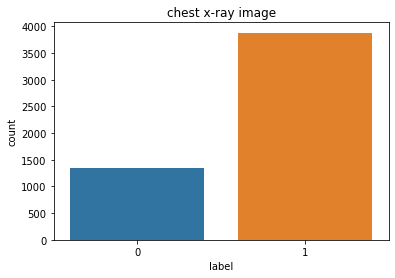

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('chest x-ray image')
sns.countplot(data['label'])

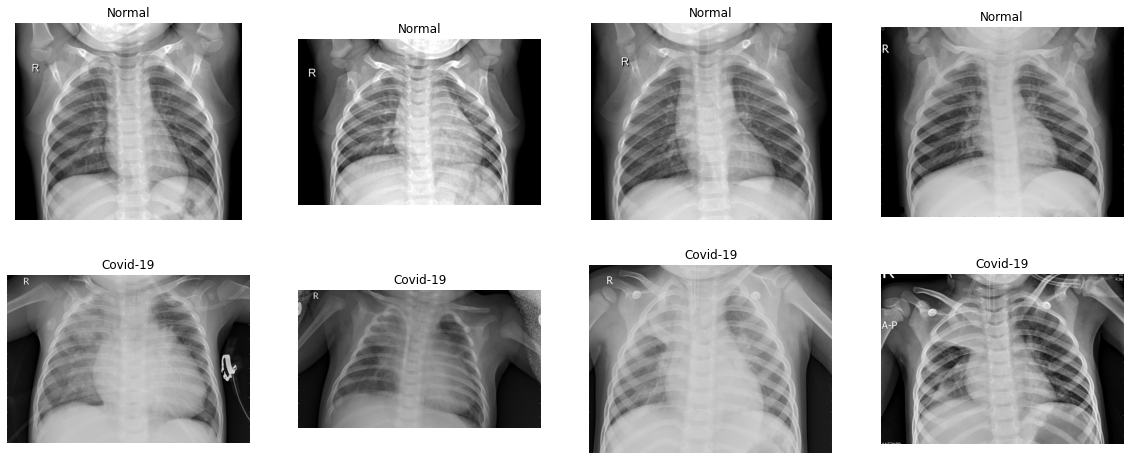

In [6]:
import cv2

plt.figure(figsize=(20,8))
for i, img_path in enumerate(data[data['label']==0][0:4]['img']):
    plt.subplot(2,4, i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')
    
for j, img_path in enumerate(data[data['label']==1][0:4]['img']):
    plt.subplot(2,4, j+5)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Covid-19')
    

In [7]:
images = '/Users/chaeseungwan/Desktop/chest_xray/train'
folders = os.listdir(images)
del folders[0]

image_data = []
labels = []

label_dict = {
    'PNEUMONIA':0,
    'NORMAL':1   
}

In [8]:
from tensorflow.keras.preprocessing import image

for ix in folders:
    path = os.path.join(images,ix)
    for im in os.listdir(path):
        img = image.load_img(os.path.join(path,im),target_size=((224,224)))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(label_dict[ix])

In [9]:
import random
combined = list(zip(image_data,labels))
random.shuffle(combined)
image_data[:],labels[:]=zip(*combined)

In [10]:
x_train = np.array(image_data)
y_train = np.array(labels)

print(x_train.shape,y_train.shape)

(5232, 224, 224, 3) (5232,)


In [11]:
from tensorflow.keras.utils import to_categorical

y_train = tf.keras.utils.to_categorical(y_train)
print(x_train.shape,y_train.shape)

(5232, 224, 224, 3) (5232, 2)


In [12]:
augment = ImageDataGenerator( 
                              rotation_range=20,
                              width_shift_range=0.01, 
                              height_shift_range=0.01, 
                              horizontal_flip=False, 
                              vertical_flip=False,
                            )
augment.fit(x_train)

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [14]:
model = Sequential()


model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=(224,224,3), activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(224,224,3), activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(224,224,3), activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(224,224,3), activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(224))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        3

In [15]:
filepath="covid_detection.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max',patience=3)
callbacks_list = [checkpoint]

hist = model.fit(x_train,y_train,
                    batch_size=64,
                    epochs = 20,
                    validation_split = 0.10, callbacks=callbacks_list)

Epoch 1/20
74/74 [==============================] - 63s 842ms/step - loss: 5.3527 - accuracy: 0.7791 - val_loss: 0.9286 - val_accuracy: 0.9637

Epoch 00001: val_accuracy improved from -inf to 0.96374, saving model to covid_detection.hdf5
Epoch 2/20
74/74 [==============================] - 60s 814ms/step - loss: 0.9338 - accuracy: 0.9462 - val_loss: 0.7820 - val_accuracy: 0.9580

Epoch 00002: val_accuracy did not improve from 0.96374
Epoch 3/20
74/74 [==============================] - 60s 813ms/step - loss: 0.7846 - accuracy: 0.9459 - val_loss: 0.6404 - val_accuracy: 0.9714

Epoch 00003: val_accuracy improved from 0.96374 to 0.97137, saving model to covid_detection.hdf5
Epoch 4/20
74/74 [==============================] - 60s 815ms/step - loss: 0.6643 - accuracy: 0.9644 - val_loss: 0.6461 - val_accuracy: 0.9580

Epoch 00004: val_accuracy did not improve from 0.97137
Epoch 5/20
74/74 [==============================] - 62s 836ms/step - loss: 0.6167 - accuracy: 0.9636 - val_loss: 0.5438 - v

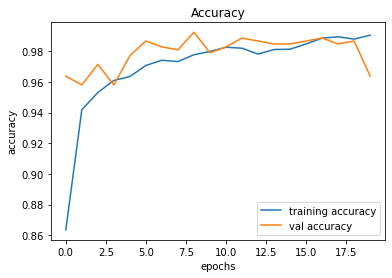

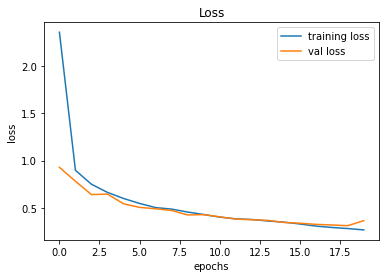

In [16]:
plt.figure(0)

plt.plot(hist.history['accuracy'], label='training accuracy')
plt.plot(hist.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [18]:
test_images = '/Users/chaeseungwan/Desktop/chest_xray/test'

test_image_data = []
test_labels = []

test_folders = os.listdir(test_images)
print(test_folders)

label_dict = {
    'PNEUMONIA':0,
    'NORMAL':1
}

from tensorflow.keras.preprocessing import image

for ix in test_folders:
    path = os.path.join(test_images,ix)
    for im in os.listdir(path):
        img = image.load_img(os.path.join(path,im),target_size = ((224,224)))
        img_array = image.img_to_array(img)
        test_image_data.append(img_array)
        test_labels.append(label_dict[ix])
        

combined = list(zip(test_image_data,test_labels))
test_image_data[:],test_labels[:] = zip(*combined)

x_test = np.array(test_image_data)
y_test = np.array(test_labels)



y_test = tf.keras.utils.to_categorical(y_test)
print(x_test.shape,y_test.shape)

['PNEUMONIA', 'NORMAL']
(624, 224, 224, 3) (624, 2)


In [45]:
predictions = model.predict(x_test, batch_size = 32)
pred = np.argmax(predictions, axis=1)

print(classification_report(test_labels, pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.85       390
           1       0.99      0.44      0.61       234

    accuracy                           0.79       624
   macro avg       0.87      0.72      0.73       624
weighted avg       0.84      0.79      0.76       624



In [20]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

In [74]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(x_train[9].astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=100)

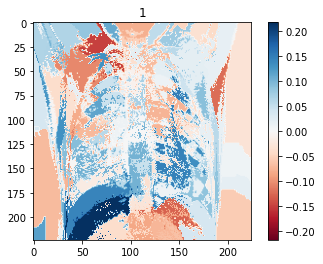

In [76]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.title(ind)
plt.colorbar()

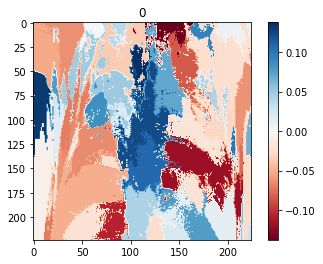

In [80]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(x_train[11].astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=100)

ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.title(ind)
plt.colorbar()